In [1]:
import h5py
import time
import torch
import pyreadr
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from pandas.api.types import CategoricalDtype
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import weight_norm
from sklearn.manifold import TSNE
from livelossplot import PlotLosses
from pytorch_model_summary import summary
from tqdm.notebook import tqdm, trange

device = torch.device('cuda')

In [2]:
from joblib import dump, load
from sklearn import metrics
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [3]:
class MyDataset(torch.utils.data.Dataset):
    '''
    Class to load the dataset
    '''
    def __init__(self, w, y, idx):
        self.w = w
        self.y = y
        self.idx = idx
            
    def __len__(self):
        return len(self.idx)

    def __getitem__(self, idx):
            
        idx = self.idx[idx]
        
        ww = torch.tensor(self.w[idx], dtype=torch.float, device = device)
        yy = torch.tensor(self.y[idx], dtype=torch.float, device = device)
        
        return (ww, yy)

In [4]:
class GatedConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, 
                 dilation=1, groups=1, bias=True):
        super(GatedConv1d, self).__init__()
        self.dilation = dilation
        self.conv_f = nn.Conv1d(in_channels, out_channels, kernel_size, 
                                stride=stride, padding=padding, dilation=dilation, 
                                groups=groups, bias=bias)
        self.conv_g = nn.Conv1d(in_channels, out_channels, kernel_size, 
                                stride=stride, padding=padding, dilation=dilation, 
                                groups=groups, bias=bias)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        padding = self.dilation - (x.shape[-1] + self.dilation - 1) % self.dilation
        x = nn.functional.pad(x, (self.dilation, 0))
        return torch.mul(self.conv_f(x), self.sig(self.conv_g(x)))

class GatedResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, output_width, stride=1, padding=0, 
                 dilation=1, groups=1, bias=True):
        super(GatedResidualBlock, self).__init__()
        self.output_width = output_width
        self.gatedconv = GatedConv1d(in_channels, out_channels, kernel_size, 
                                     stride=stride, padding=padding, 
                                     dilation=dilation, groups=groups, bias=bias)
        self.conv_1 = nn.Conv1d(out_channels, out_channels, 1, stride=1, padding=0,
                                dilation=1, groups=1, bias=bias)

    def forward(self, x):
        skip = self.conv_1(self.gatedconv(x))
        residual = torch.add(skip, x)

        skip_cut = skip.shape[-1] - self.output_width
        skip = skip.narrow(-1, skip_cut, self.output_width)
        return residual, skip


In [5]:
# class Model(nn.Module):
#     def __init__(self, num_channels = 7, output_width = 300, num_classes = 1,num_blocks = 1, num_layers = 7, num_hidden=128, kernel_size=3):
#         super(Model, self).__init__()
#         self.num_channels = num_channels
#         self.num_classes = num_classes
#         self.num_blocks = num_blocks
#         self.num_layers = num_layers
#         self.num_hidden = num_hidden
#         self.kernel_size = kernel_size
#         self.output_width = output_width
#         self.receptive_field = 1 + (kernel_size - 1) * num_blocks * sum([2**k for k in range(num_layers)])
#         print('receptive_field: {}'.format(self.receptive_field))
        
#         hs = []
#         batch_norms = []

#         # add gated convs
#         first = True
        
#         for b in range(num_blocks):
#             for i in range(num_layers):
#                 rate = 2**i
#                 if first:
#                     h = GatedResidualBlock(num_channels, num_hidden, kernel_size, dilation=rate)
#                     first = False
#                 else:
#                     h = GatedResidualBlock(num_hidden, num_hidden, kernel_size, dilation=rate)
#                 h.name = 'b{}-l{}'.format(b, i)

#                 hs.append(h)
#                 batch_norms.append(nn.BatchNorm1d(num_hidden))

#         self.hs = nn.ModuleList(hs)
#         self.batch_norms = nn.ModuleList(batch_norms)
#         self.relu_1 = nn.ReLU()
#         self.conv_1_1 = nn.Conv1d(num_hidden, num_hidden, 1)
#         self.relu_2 = nn.ReLU()
#         self.conv_1_2 = nn.Conv1d(num_hidden, num_hidden, 1)
#         self.h_class = nn.Conv1d(num_hidden, num_classes, 2)

#     def forward(self, x):
#         skips = []
#         for layer, batch_norm in zip(self.hs, self.batch_norms):
#             x, skip = layer(x)
#             x = batch_norm(x)
#             skips.append(skip)

#         x = reduce((lambda a, b : torch.add(a, b)), skips)
#         x = self.relu_1(self.conv_1_1(x))
#         x = self.relu_2(self.conv_1_2(x))
#         return self.h_class(x)


In [6]:
class Model(nn.Module):
    def __init__(self, 
                 num_time_samples = 300 + 256,
                 num_channels=7,
                 num_classes=1,
                 num_blocks=2,
                 num_layers=7,
                 num_hidden=128,
                 kernel_size=2):
        super(Model, self).__init__()
        self.num_time_samples = num_time_samples
        self.num_channels = num_channels
        self.num_classes = num_classes
        self.num_blocks = num_blocks
        self.num_layers = num_layers
        self.num_hidden = num_hidden
        self.kernel_size = kernel_size
        self.receptive_field = 1 + (kernel_size - 1) * \
                               num_blocks * sum([2**k for k in range(num_layers)])
        self.output_width = num_time_samples - self.receptive_field + 1
        print('receptive_field: {}'.format(self.receptive_field))
        print('Output width: {}'.format(self.output_width))
        

        hs = []
        batch_norms = []

        # add gated convs
        first = True
        for b in range(num_blocks):
            for i in range(num_layers):
                rate = 2**i
                if first:
                    h = GatedResidualBlock(num_channels, num_hidden, kernel_size, 
                                           self.output_width, dilation=rate)
                    first = False
                else:
                    h = GatedResidualBlock(num_hidden, num_hidden, kernel_size,
                                           self.output_width, dilation=rate)
                h.name = 'b{}-l{}'.format(b, i)

                hs.append(h)
                batch_norms.append(nn.BatchNorm1d(num_hidden))

        self.hs = nn.ModuleList(hs)
        self.batch_norms = nn.ModuleList(batch_norms)
        self.relu_1 = nn.ReLU()
        self.conv_1_1 = nn.Conv1d(num_hidden, num_hidden, 1)
        self.relu_2 = nn.ReLU()
        self.conv_1_2 = nn.Conv1d(num_hidden, num_hidden, 1)
        self.h_class = nn.Conv1d(num_hidden, num_classes, 2)

    def forward(self, x):
        skips = []
        for layer, batch_norm in zip(self.hs, self.batch_norms):
            x, skip = layer(x)
            x = batch_norm(x)
            skips.append(skip)

        x = reduce((lambda a, b : torch.add(a, b)), skips)
        x = self.relu_1(self.conv_1_1(x))
        x = self.relu_2(self.conv_1_2(x))
        return self.h_class(x)


In [7]:
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=7, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = nn.ModuleList()
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            tbl = TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)
            layers.append(tbl)
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [8]:
class MyNet(nn.Module):

    def __init__(self, w_layers, d):

        super().__init__()
        self.tcn = TemporalConvNet(w_layers[0], w_layers[1:], kernel_size=2, dropout=d)
   
    def forward(self, Ws):
        pred = self.tcn(Ws)
        return pred
        return (torch.cumsum(torch.tanh(pred), -1))


In [9]:
w_file = '../data/w_dm.npy'
y_file = '../data/y_dm.npy'

In [10]:
w = np.load(w_file)
ws = np.array([[[5e4,50,50,5,10,100]]])
w = w / ws
W = np.moveaxis(w, 1, 2)
wd = np.linspace(-0.9,2.1,300)[None,None]
wd = wd.repeat(len(W), 0)
W = np.concatenate([W, wd], 1)

In [11]:
y = np.load(y_file)[:,None]/2e4

In [12]:
idx_max = y[:,0,-1].argmax()
idx_min = y[:,0,-1].argmin()

In [13]:
pred_idx = np.arange(len(y))
val_idx = np.random.choice(pred_idx, size=300, replace=False)
train_idx = np.setdiff1d(pred_idx, val_idx)
print(train_idx.shape, val_idx.shape)

(2763,) (300,)


In [14]:
batch_size = 100

pred_dataset = MyDataset(W, y, pred_idx)
train_dataset = MyDataset(W, y, train_idx)
val_dataset = MyDataset(W, y, val_idx)


pred_loader = DataLoader(pred_dataset, batch_size=batch_size, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

data_inputs = iter(train_loader).next()
print(len(train_loader))



28


In [15]:
d = 0.1
w_layers = [7, 128, 64, 32, 32, 16, 16, 16, 16, 1]

model = MyNet(w_layers, d)
# model = Model()
model = model.to(device)

model_file_name = '../data/model_tcn.pth'        
model_file_name = '../data/model_tcn_v2.pth'
# model.load_state_dict(torch.load(model_file_name, map_location=device))
model_file_name = '../data/model_tcn_v3.pth'        

sm = summary(model, data_inputs[0], print_summary=True,  max_depth=2)

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
   TemporalBlock-1     [100, 128, 300]          53,376          53,376
   TemporalBlock-2      [100, 64, 300]          45,376          45,376
   TemporalBlock-3      [100, 32, 300]          11,424          11,424
   TemporalBlock-4      [100, 32, 300]           6,272           6,272
   TemporalBlock-5      [100, 16, 300]           2,896           2,896
   TemporalBlock-6      [100, 16, 300]           1,600           1,600
   TemporalBlock-7      [100, 16, 300]           1,600           1,600
   TemporalBlock-8      [100, 16, 300]           1,600           1,600
   TemporalBlock-9       [100, 1, 300]              72              72
Total params: 124,216
Trainable params: 124,216
Non-trainable params: 0
-----------------------------------------------------------------------


In [16]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [17]:
min_loss = 10
bad_epochs = 0
liveloss = PlotLosses()

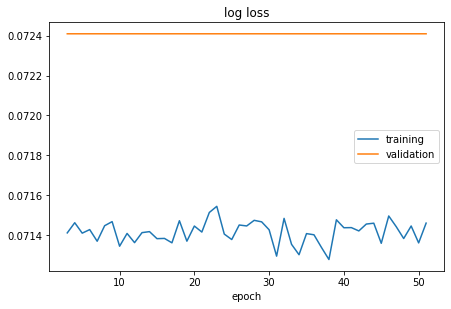

log loss:
training   (min:    0.071, max:    0.072, cur:    0.071)
validation (min:    0.072, max:    0.072, cur:    0.072)
[50:50] loss: 0.071 time:3.05


In [18]:
for epoch in range(1000):
    start_time = time.time()
    epoch_loss = []
    val_loss = []
    
    model.train()
    for i, (Ws, Ys) in enumerate(tqdm(train_loader)):
        
        # Limpa os gradientes
        optimizer.zero_grad()
    
        # Obtem o output
#         Ws = Ws + 0.01 * torch.rand_like(Ws)
        outputs = model(Ws)

        # Caulcula a perda pela loss function
        loss = criterion(outputs, Ys)
        
        # Obtem os gradientes
        loss.backward()

        # Atualiza os parâmetros
        optimizer.step()
        epoch_loss.append(loss.data.item())
        
    model.eval()
    for i, (Ws, Ys) in enumerate(tqdm(val_loader)):
        with torch.no_grad():
          # Obtem o output
          outputs = model(Ws)

        # Caulcula a perda pela loss function (MSE)
        loss = criterion(outputs, Ys)

        val_loss.append(loss.data.item())
        
    epoch_loss = np.array(epoch_loss).mean()
    val_loss = np.array(val_loss).mean()
    time_taken = time.time() - start_time
    
    if val_loss < min_loss:
        # Nome da pasta com o arquivo .pth salvando os pesos do modelo treinado
        torch.save(model.state_dict(), model_file_name)
        bad_epochs = 0
        min_loss = val_loss
    else:
        bad_epochs += 1
    
    if bad_epochs > 50:
        break

    liveloss.update({
        'log loss': epoch_loss,
        'val_log loss': val_loss
    })
    liveloss.draw() #Apresenta o gráfico log loss
    print('[%d:%d] loss: %.3f time:%.2f' % (bad_epochs, epoch, epoch_loss, time_taken))


In [19]:
model.load_state_dict(torch.load(model_file_name, map_location=device))
print('Model OK')

Model OK


In [20]:
# Inicia o tempo para contagem
start_time = time.time()

# Realiza a predição dos dados a partir do modelo treinado - Dados de validação
model.eval()
obs = []
preds = []
for i, (Ws, Ys) in enumerate(tqdm(val_loader)):
    obs.append(Ys.cpu().data.numpy())
    with torch.no_grad():
        pred = model(Ws)
    preds.append(pred.cpu().data.numpy())
obs = np.concatenate(obs)
preds = np.concatenate(preds)

# Faz a diferença para calcular o tempo           
time_taken = time.time() - start_time
# Apresenta o valor do tempo
print('time:%.2f' % (time_taken))


time:0.07


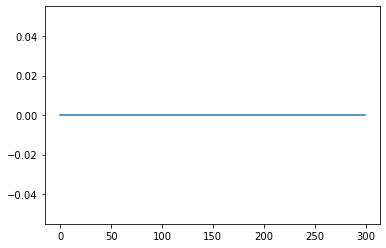

In [21]:
plt.plot(preds[10,0])

nan


/opt/anaconda3/envs/GEOANN/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/anaconda3/envs/GEOANN/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


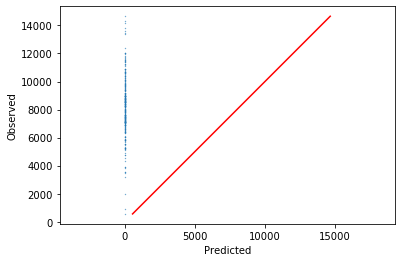

In [22]:
x = preds[:,0,-1].reshape(-1) * 2e4
y = obs[:,0,-1].reshape(-1) * 2e4

ax = plt.axes()
ax.set_aspect('equal', 'datalim')

plt.scatter(x, y, 0.1, alpha=0.9)
plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k-', color = 'r')
print(np.round(np.corrcoef(x, y, rowvar=False)[1,0],3))
plt.show()

In [23]:
ymin = pred_dataset[idx_min][1][None].cpu().data.numpy()
ymax = pred_dataset[idx_max][1][None].cpu().data.numpy()
wmax = pred_dataset[idx_min][0][None]
wmax.requires_grad = True

In [24]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam([wmax], lr=0.01)

In [25]:
liveloss = PlotLosses()

In [26]:
outputs = model(wmax)

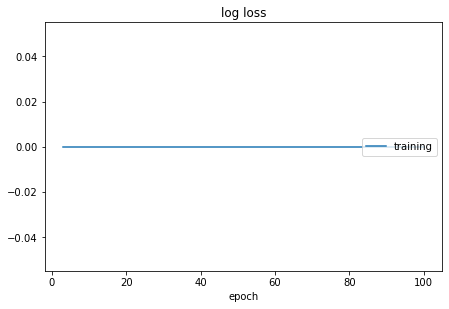

log loss:
training   (min:   -0.000, max:   -0.000, cur:   -0.000)


In [27]:
model.eval()
for i in trange(100):

    # Limpa os gradientes
    optimizer.zero_grad()

    # Obtem o output
    wmaxx = F.dropout(wmax, 0.5)
    outputs = model(wmax)

    # Caulcula a perda pela loss function
    loss =  -outputs[0,0,-1]
    
    # Obtem os gradientes
    loss.backward()

    # Atualiza os parâmetros
    optimizer.step()
    
    liveloss.update({
        'log loss': loss.item()
    })
liveloss.draw()

In [28]:
pred = outputs.cpu().data.numpy()

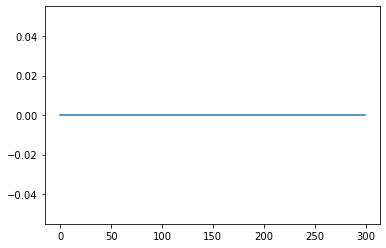

In [29]:
plt.plot(pred[0,0])

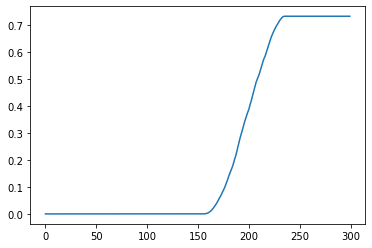

In [30]:
plt.plot(ymax[0,0])

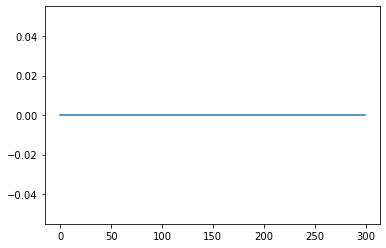

In [31]:
plt.plot(ymin[0,0])